In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [3]:
from btdsa.config import Config, BASELINE_MODEL_FAMILY, TDSA_MODEL_LIST
from btdsa.eval_utils import EvalSurv
from btdsa.train_utils import init_trainer
from btdsa.utils import create_logger
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
def inference(model_name, dataset, time_range='full', experiment_root='../experiments'):
    ev = EvalSurv()  # custom evaluation interface

    cfg = Config
    cfg.model_name = model_name
    cfg.time_range = time_range
    cfg.random_state = 1234 # will be repeated across multiple random_state variables
    cfg.model_save_dir = Path(experiment_root) / cfg.model_save_dir
    cfg.setup()
    
    weight_file = cfg.model_save_dir / f"{model_name}_{time_range}_L{cfg.seq_len}_{dataset}.pth"
    trainer = init_trainer(cfg)
    surv, model = trainer.fit_and_predict(dataset, weight_file=weight_file)
    ev.trainer = trainer
    x_test, y_test = trainer.test
    ev.evaluate(surv, x_test, y_test)
    labtrans = trainer.labtrans
    
    return surv, model, x_test, y_test, labtrans, trainer

In [5]:
surv, model, x_test, y_test, labtrans, trainer = inference('BTDSA', dataset='metabric', 
                                                  experiment_root='../tests' # will be changed to ../experiments
                                                 )

## Survival Functions

In [6]:
from pycox.models import utils
import pandas as pd

def plot_interpolated_survival_curve(surv, model, n_samples=5):
    surv = surv[:, :-1]
    duration_index = model.duration_index[:-1]
    index = utils.make_subgrid(duration_index, 100)
    surv_df = pd.DataFrame(surv.transpose()[:len(index)], index)
    surv_df.iloc[:, :n_samples].plot(xlabel='Time', ylabel="Survival Rate", grid=True)
    return surv_df

def plot_hazard_from_surv(surv_df, model, n_samples=5):
    hazard = (surv_df.diff(periods=-1, axis=0) / surv_df)
    hazard.iloc[:, :n_samples].plot(xlabel='Time', ylabel='Probability of Event', grid=True)

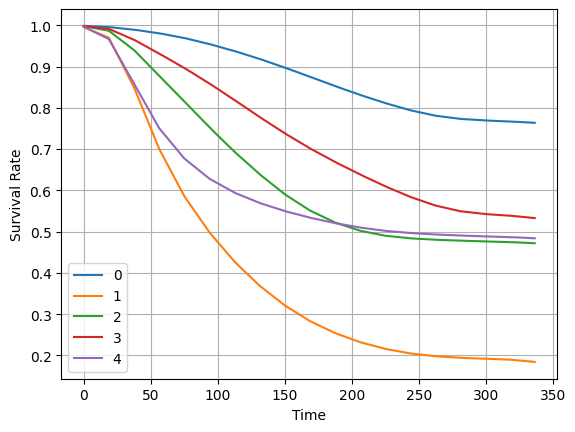

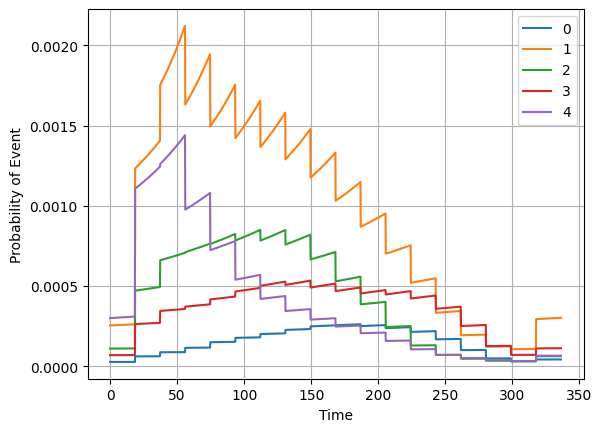

In [7]:
n_samples = 5
if trainer.interpolate_discrete_times:
    surv_df = plot_interpolated_survival_curve(surv, model, n_samples=n_samples)
    hazard = (surv_df.diff(periods=-1, axis=0) / surv_df)
    hazard.iloc[:, :n_samples].plot(xlabel='Time', ylabel='Probability of Event', grid=True)
else:
    surv_df = surv.iloc[:-1, :n_samples]
    surv_df.plot(xlabel='Time', ylabel="Survival Probability", grid=True)
    plot_hazard_from_surv(surv_df, model, n_samples=n_samples)

In [8]:
hazard.shape

(1801, 571)

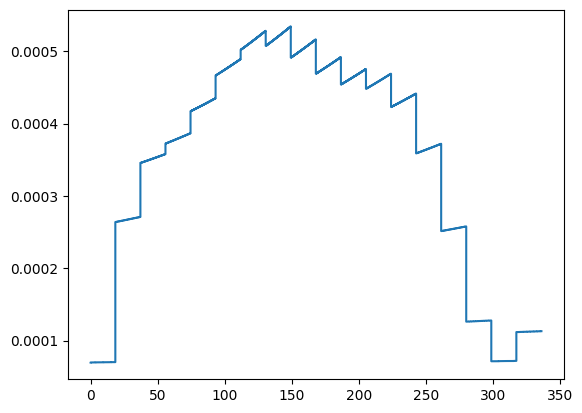

In [9]:
h = hazard.iloc[:, 3]
plt.step(h.index, h)

In [10]:
y_test[:5]

array([[274.3666687 ,   0.        ],
       [ 21.29999924,   1.        ],
       [194.        ,   0.        ],
       [110.93333435,   1.        ],
       [ 35.70000076,   1.        ]])

## Hazard rate across time space
- hazard rate : probability of the event (0~1); RNN outputs

In [11]:
uncen_idxs = np.where(y_test[:, 1]==1)

In [12]:
x_uncen = x_test[uncen_idxs]
y_uncen = y_test[uncen_idxs]

In [13]:
net = model.net
net

TDSA(
  (lstm): LSTM(206, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (params_to_train): ModuleList(
    (0): Embedding(2, 50)
    (1): Embedding(2, 50)
    (2): Embedding(2, 50)
    (3): Embedding(2, 50)
  )
)

In [14]:
# hazard_rate = net(torch.from_numpy(x_uncen).cuda()).squeeze().detach().cpu().numpy()
# hazard_rate

In [15]:
surv

array([[0.9983115 , 0.99828374, 0.99825597, ..., 0.40450436, 0.40084013,
        0.3971759 ],
       [0.9951984 , 0.99494433, 0.99469024, ..., 0.02779792, 0.02620038,
        0.02460284],
       [0.99764925, 0.99753886, 0.9974284 , ..., 0.14870563, 0.14540833,
        0.14211103],
       ...,
       [0.99823487, 0.9981962 , 0.99815756, ..., 0.34899485, 0.34541643,
        0.34183797],
       [0.9981009 , 0.9980276 , 0.99795437, ..., 0.3131389 , 0.30948928,
        0.3058397 ],
       [0.9975617 , 0.9974177 , 0.9972737 , ..., 0.20493597, 0.2018283 ,
        0.19872063]], dtype=float32)

In [16]:
hazard_rate = model.predict_pmf(x_uncen)
hazard_rate.shape

(329, 20)

In [17]:
durations, events = y_uncen.T
print("Max duration: ", durations.max())

Max duration:  300.70001220703125


In [18]:
durations_idx, events = labtrans.transform(durations, events)

In [19]:
x_uncen.shape

(329, 20, 10)

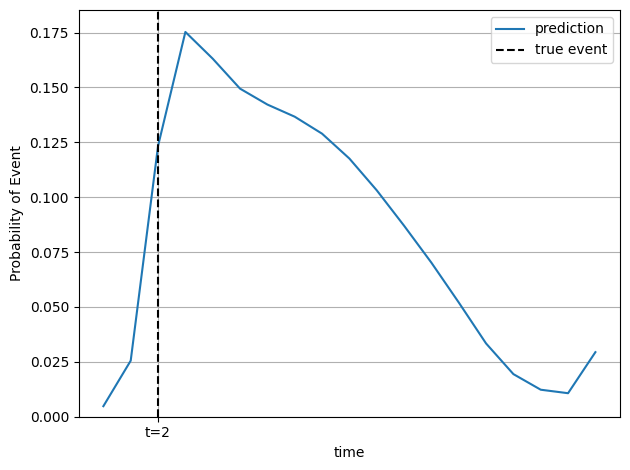

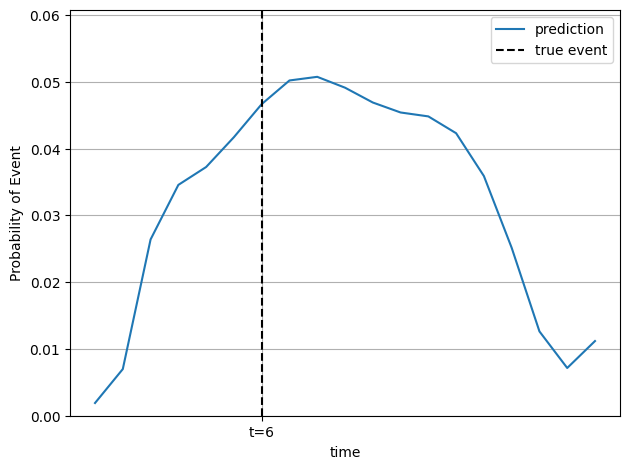

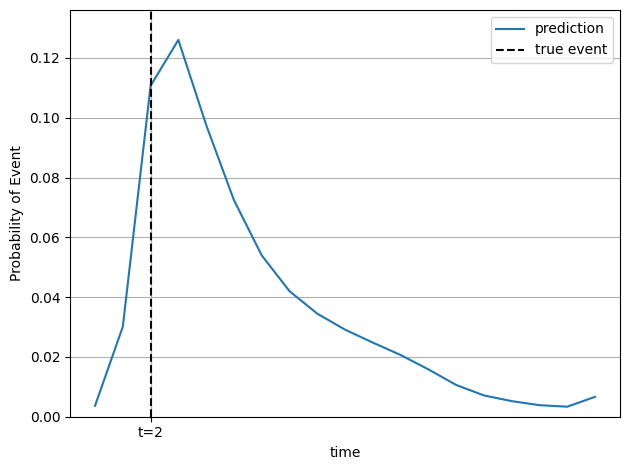

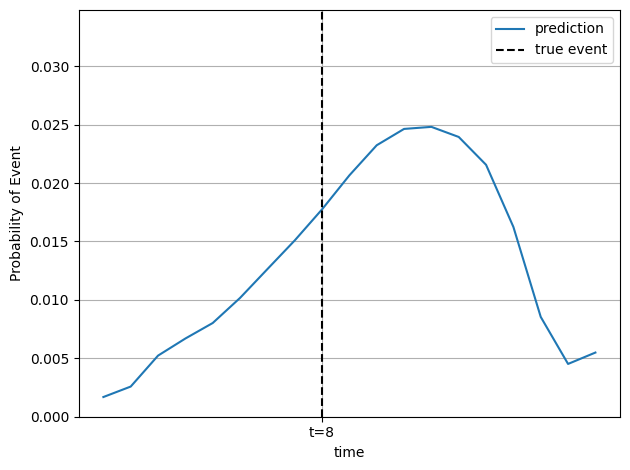

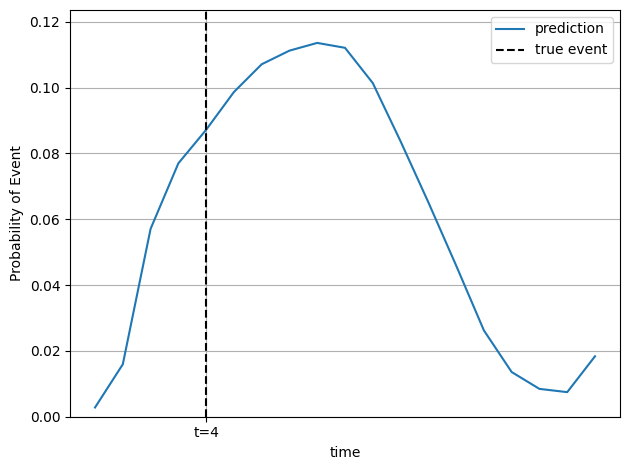

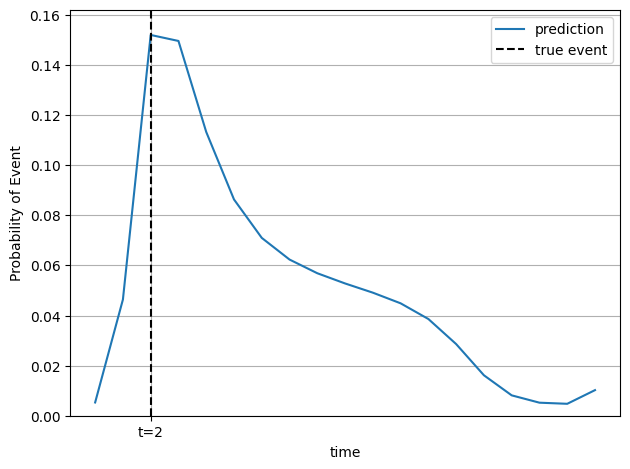

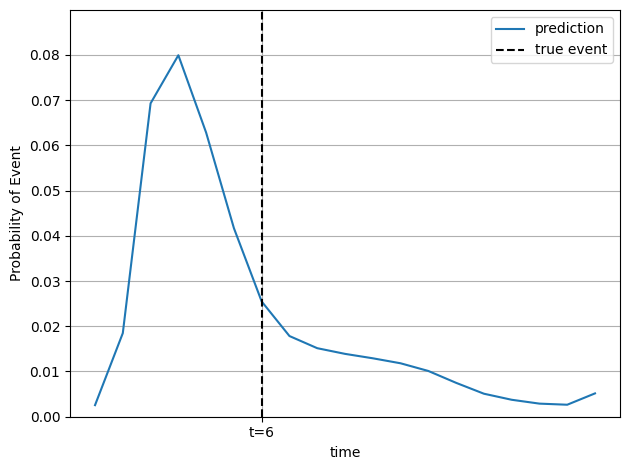

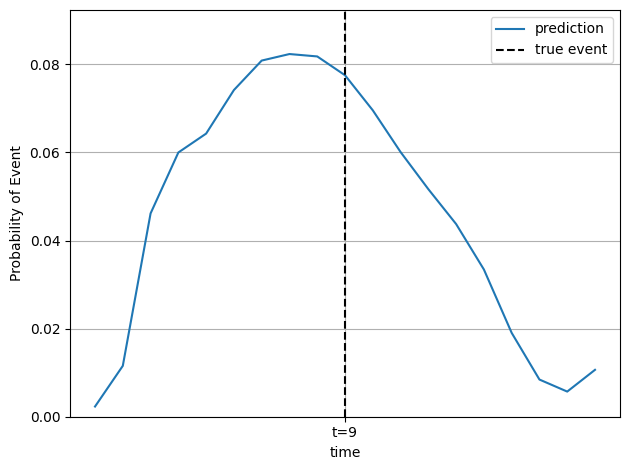

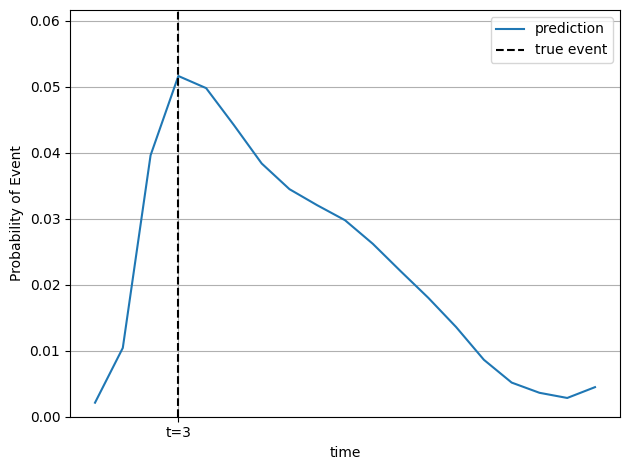

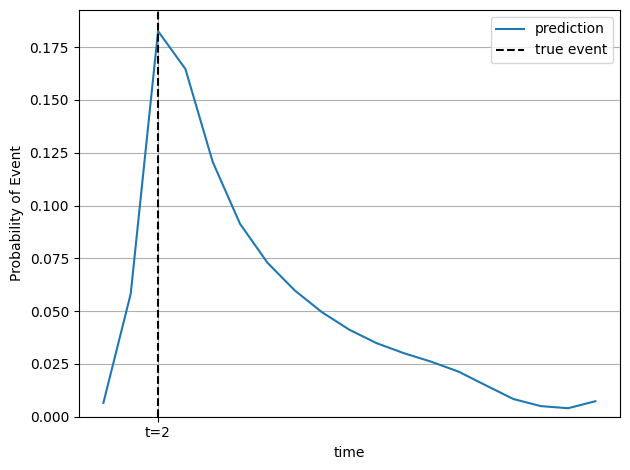

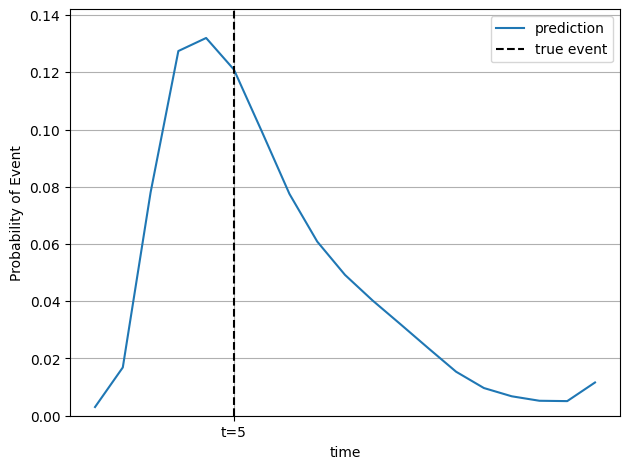

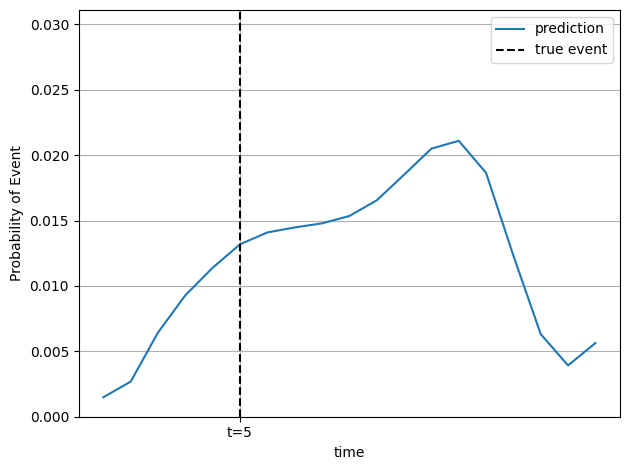

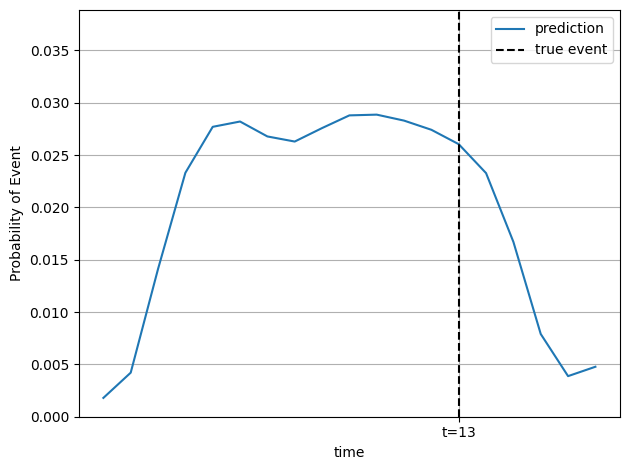

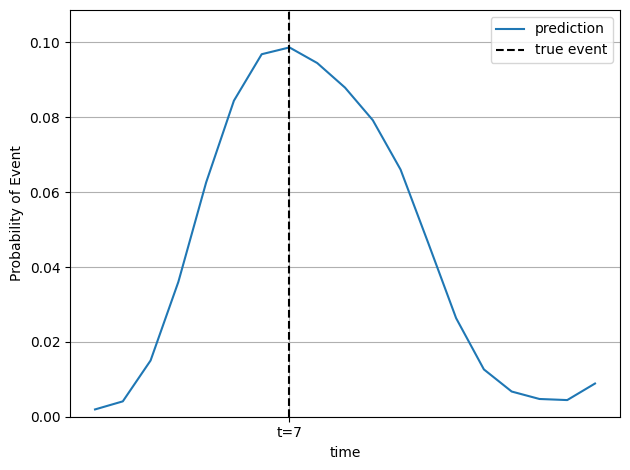

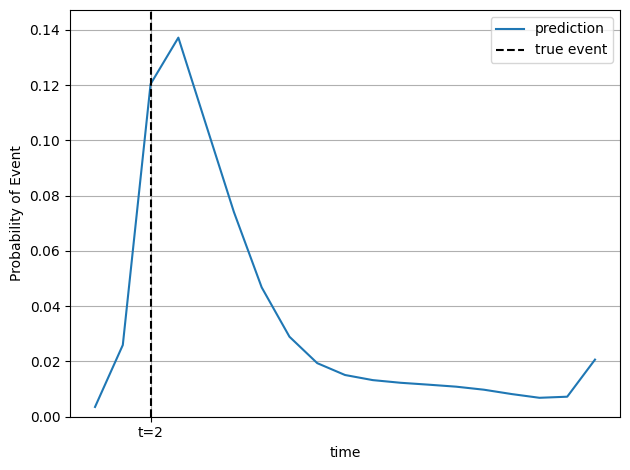

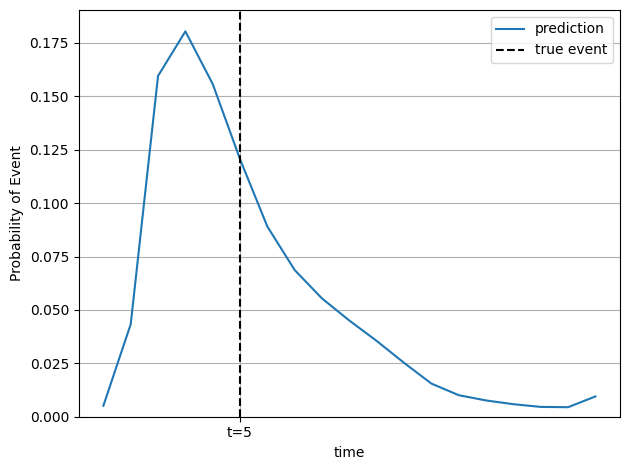

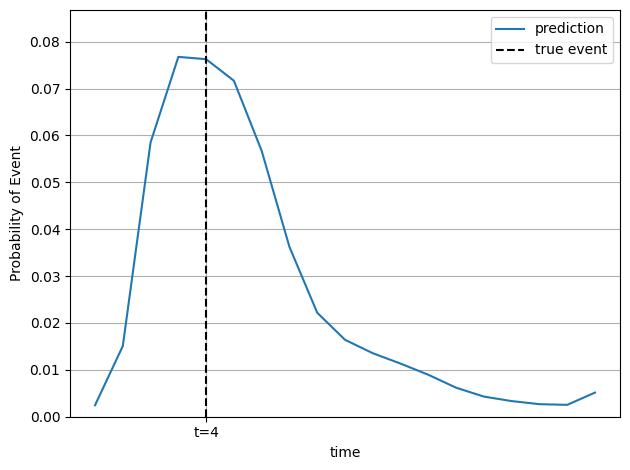

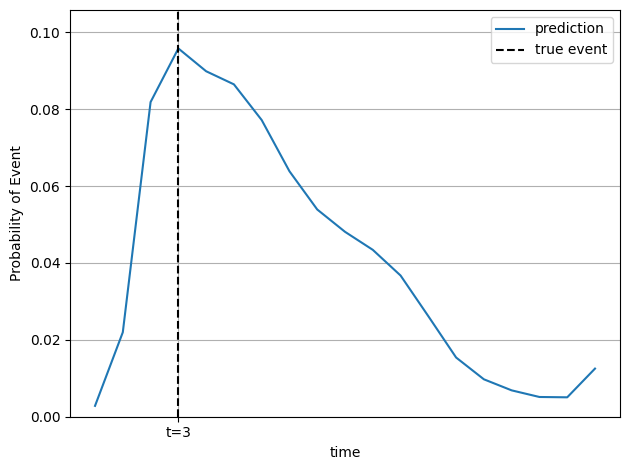

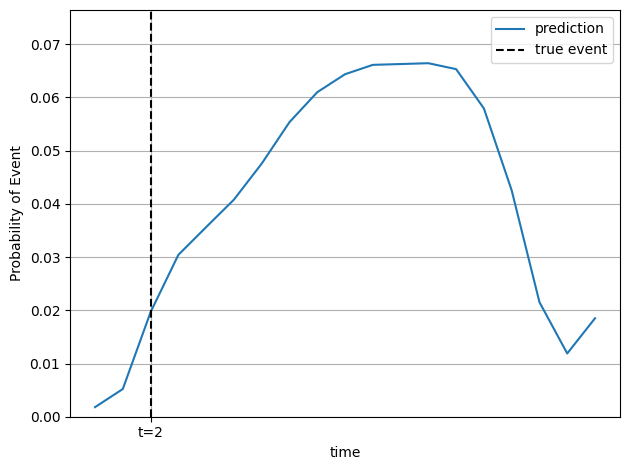

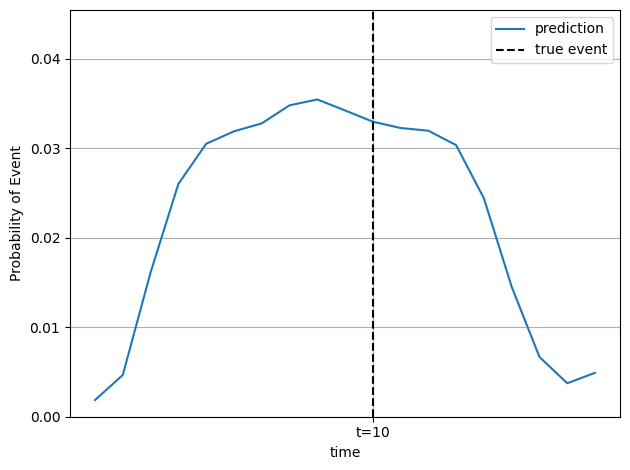

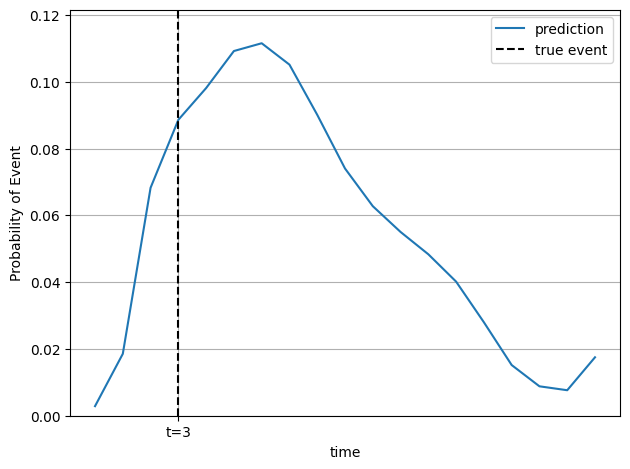

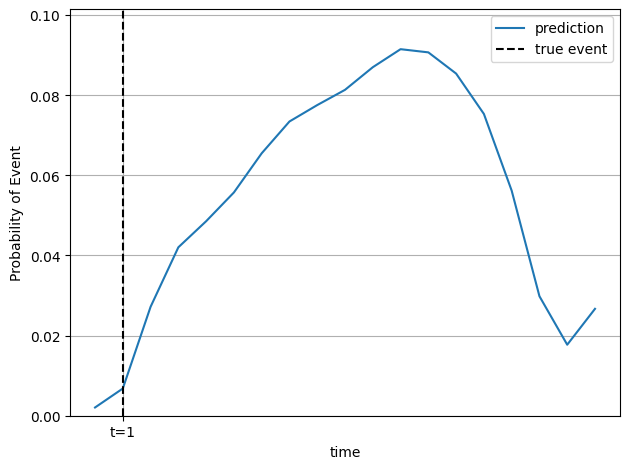

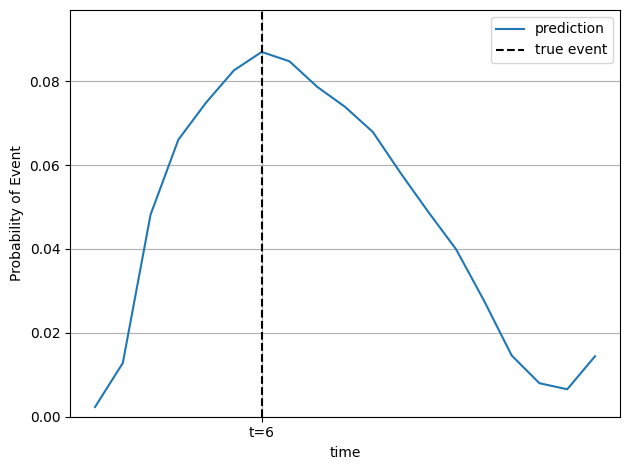

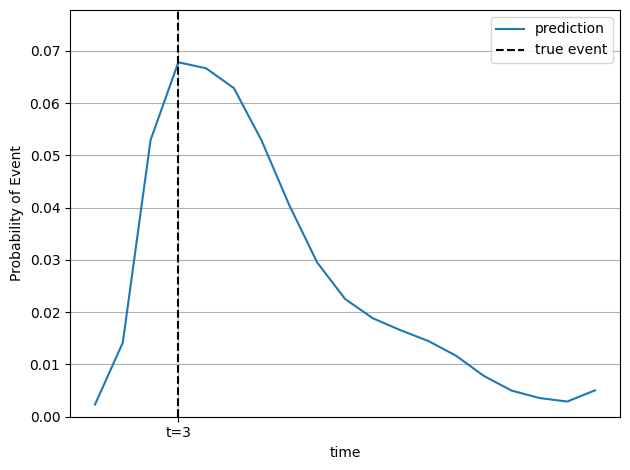

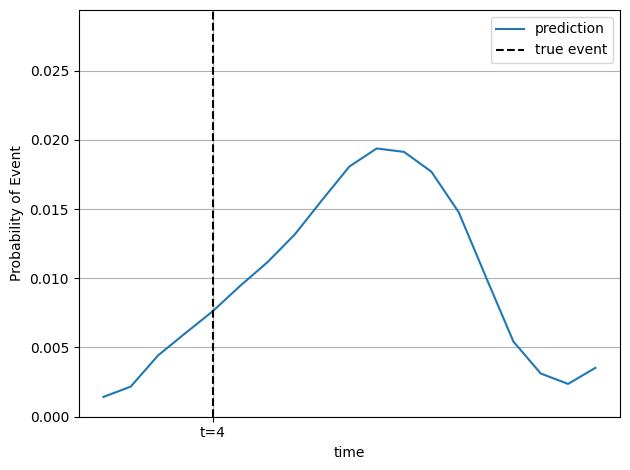

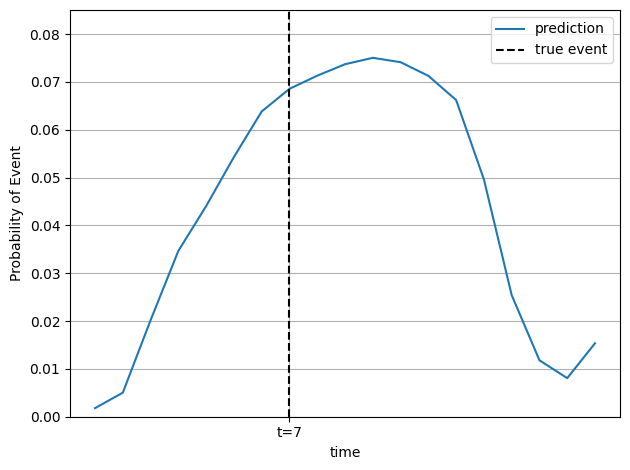

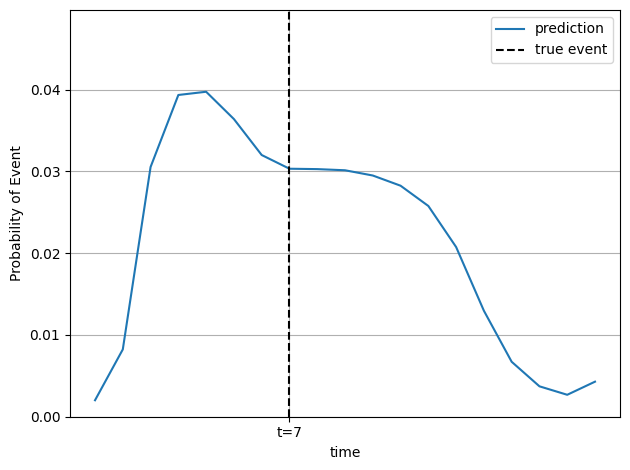

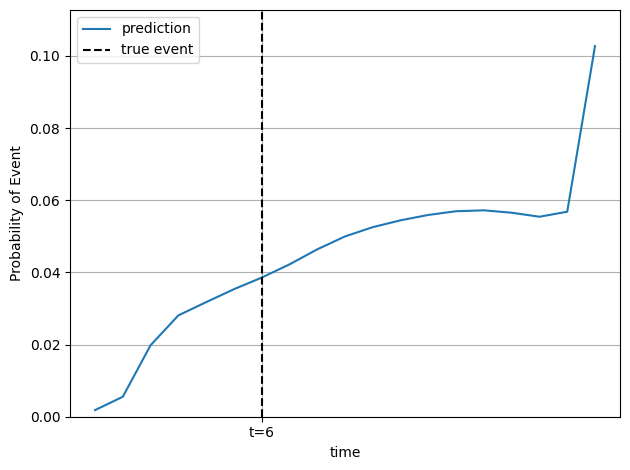

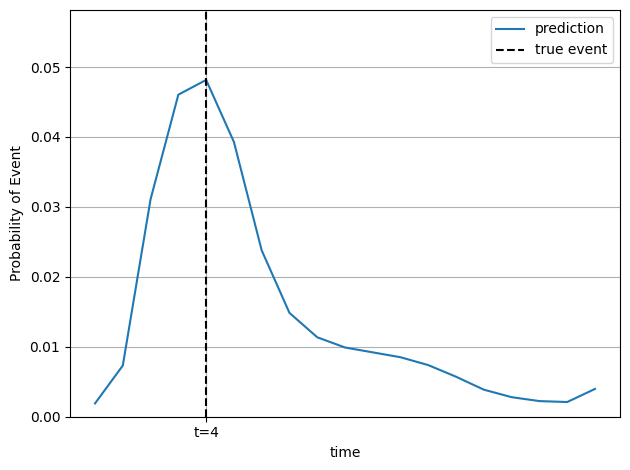

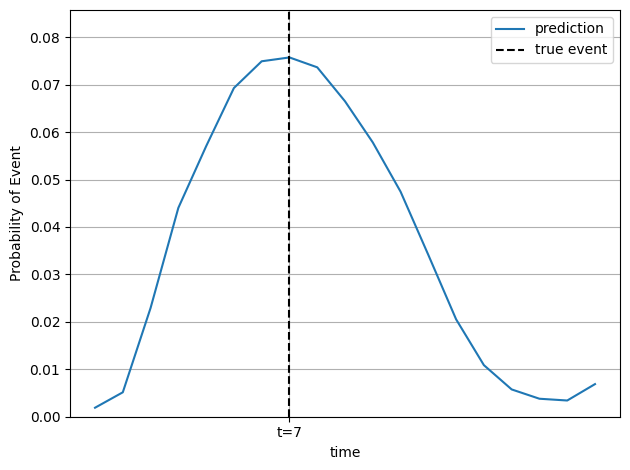

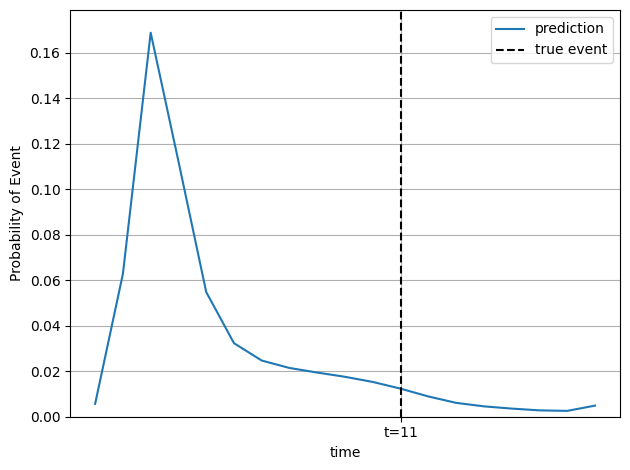

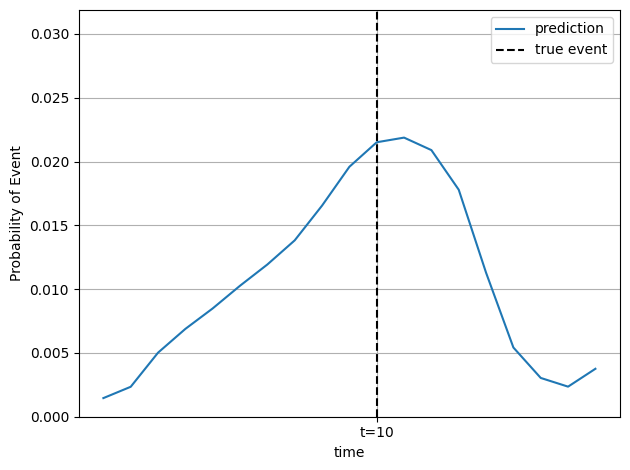

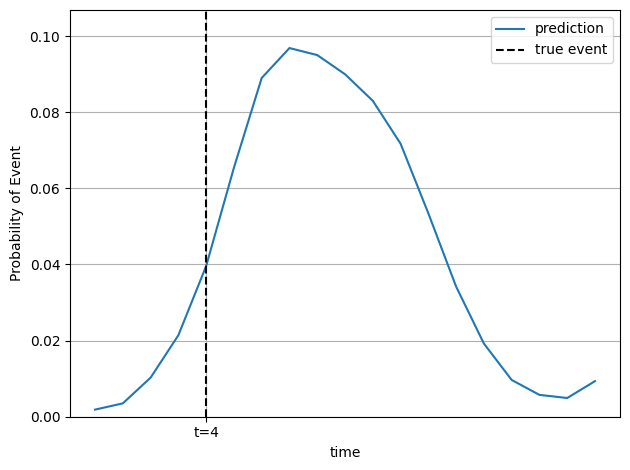

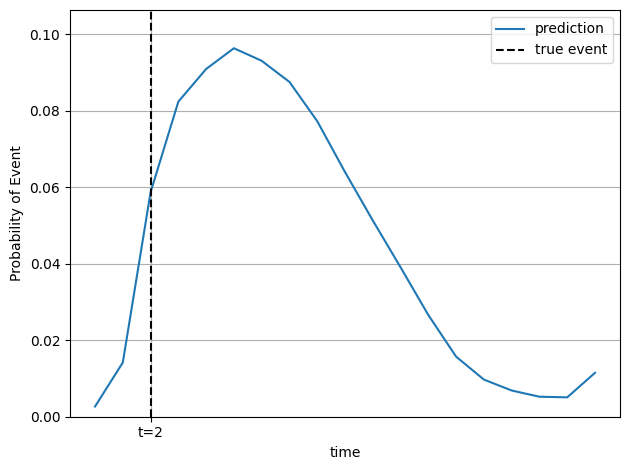

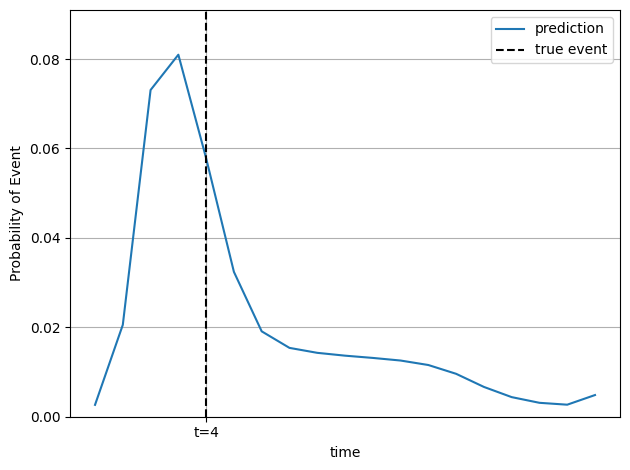

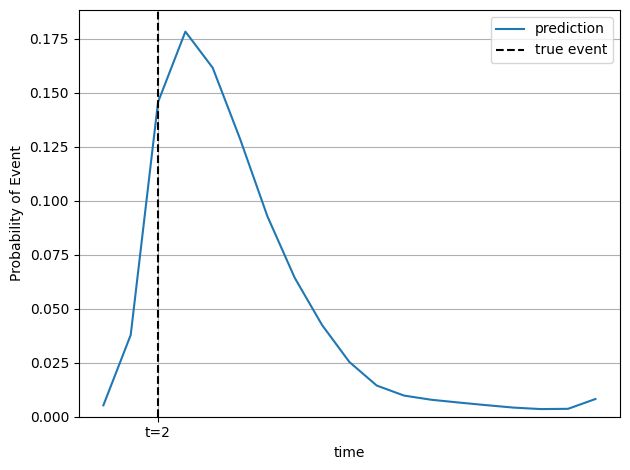

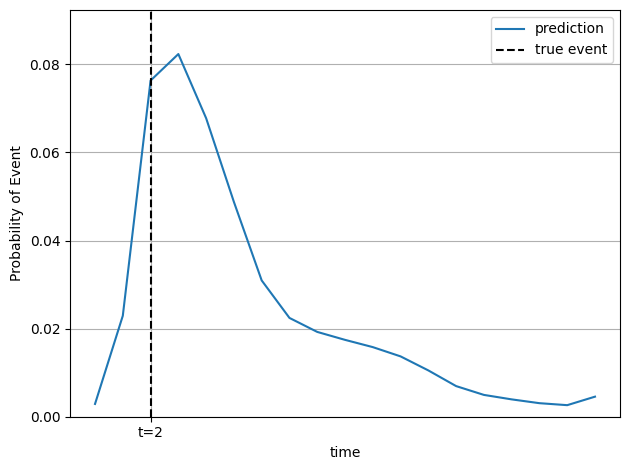

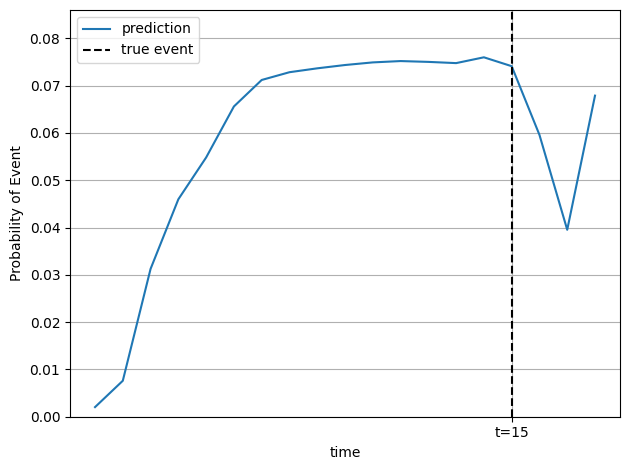

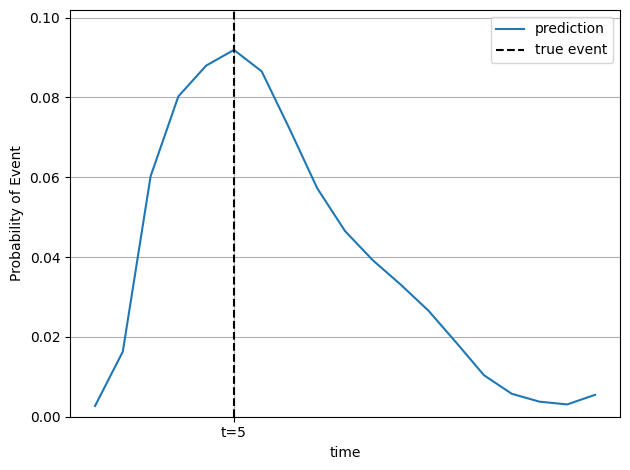

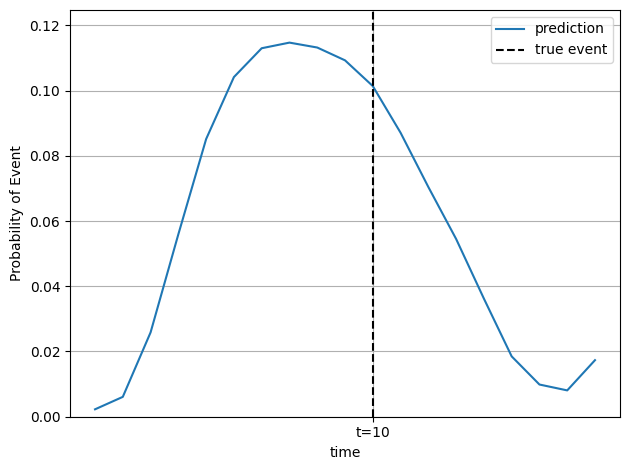

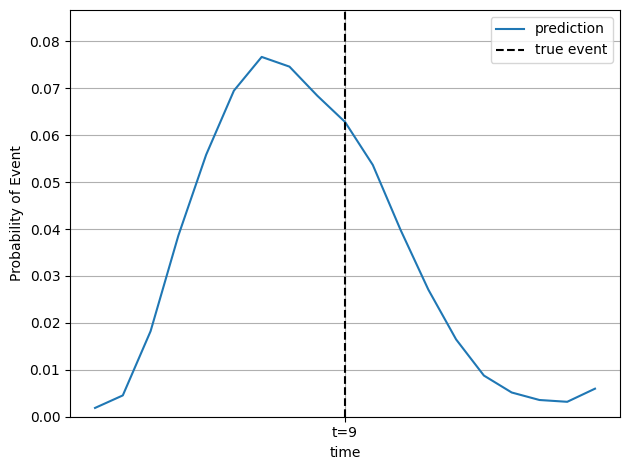

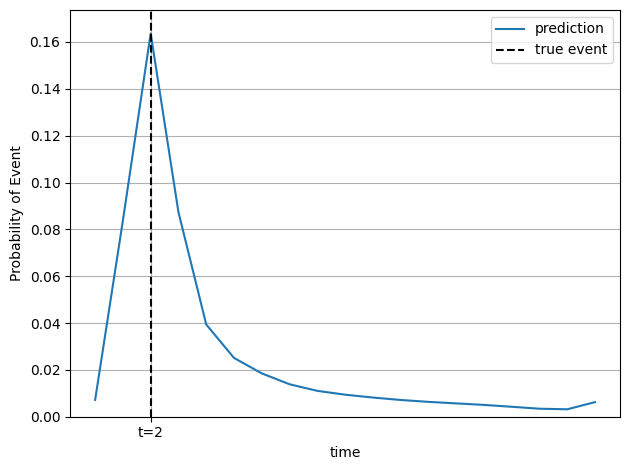

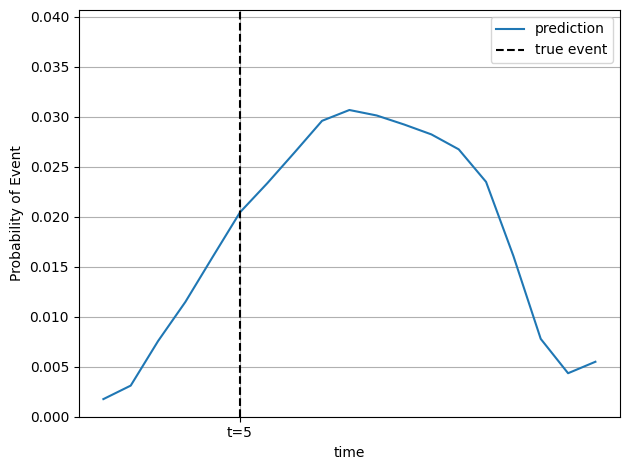

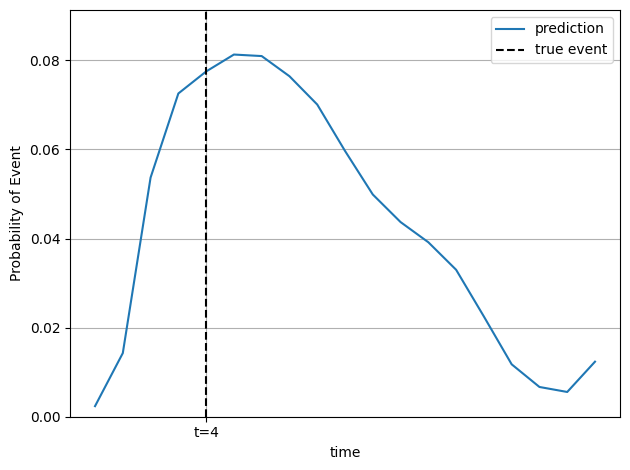

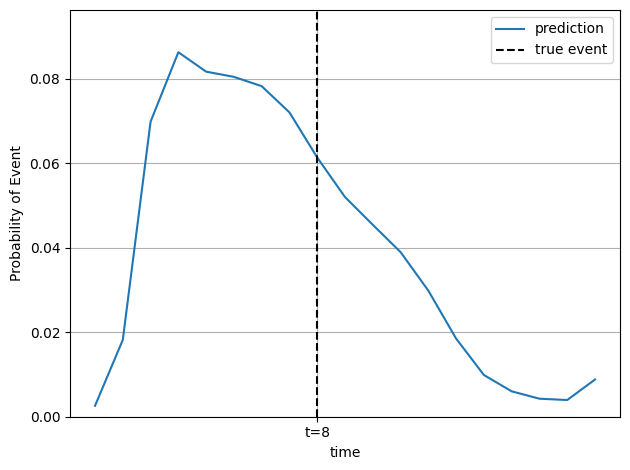

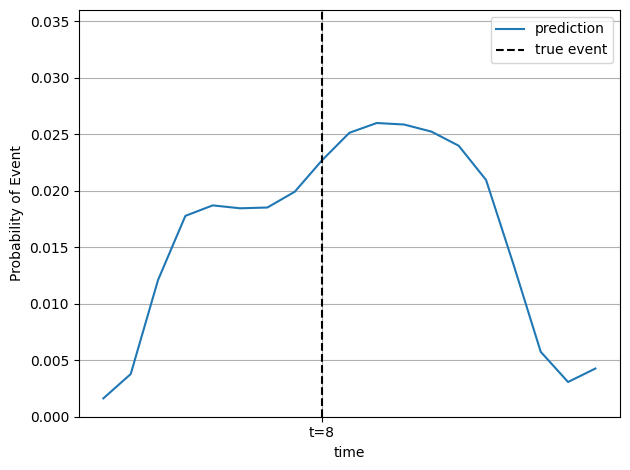

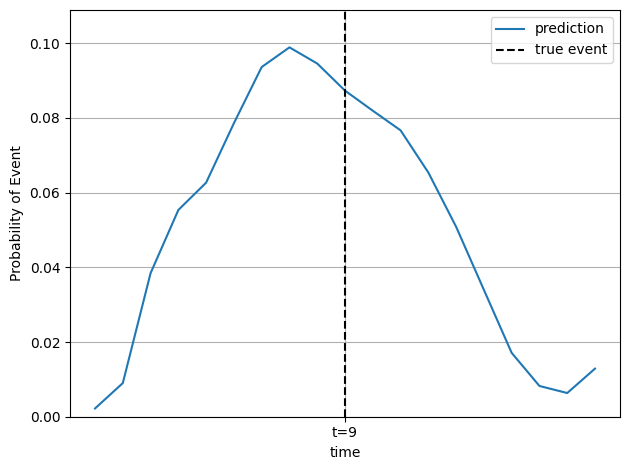

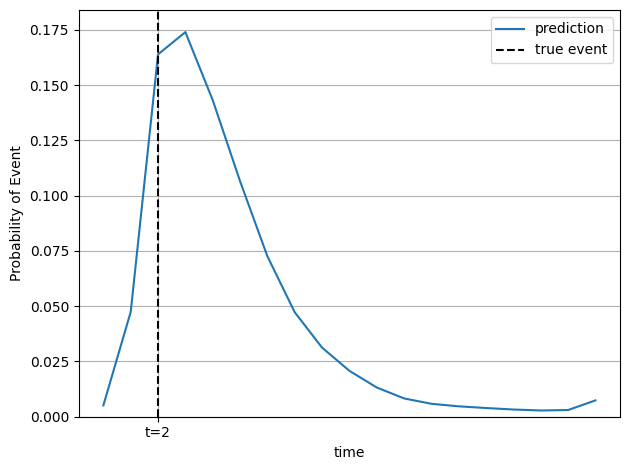

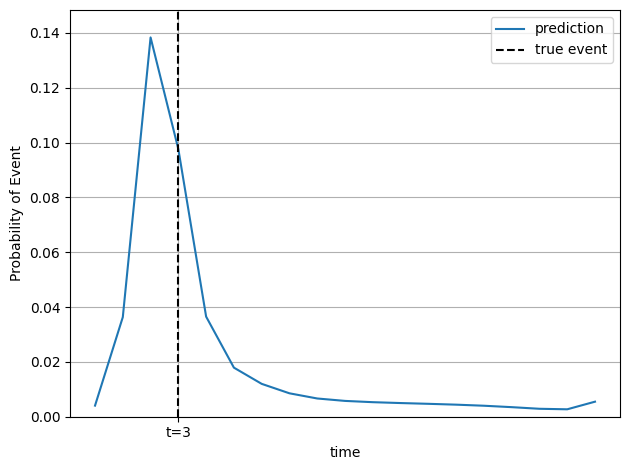

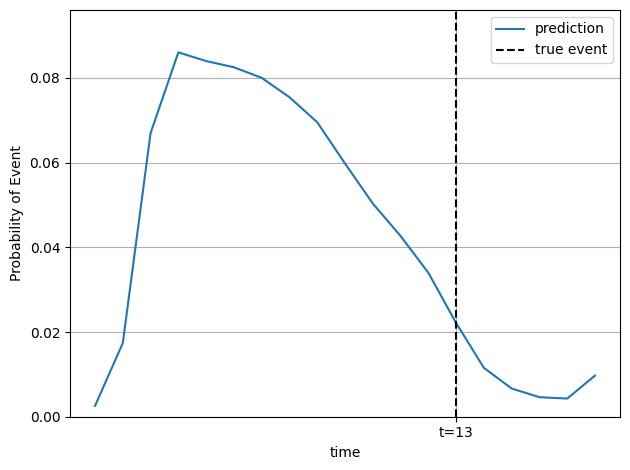

In [20]:
vmargin = 1e-2
for i, hz in enumerate(hazard_rate[:50]):
    hz = hz[:-1] # exclude last time step
    true_event_time_index = durations_idx[i]
    #plt.stem(range(len(hz)), hz, label='hazard')
    plt.plot(range(len(hz)), hz, label='prediction')
    plt.vlines(true_event_time_index, 0, hz.max()+vmargin, colors='k', linestyle='--', label='true event')
    plt.xticks([true_event_time_index], labels=[f't={true_event_time_index}'])
    plt.xlabel('time')
    plt.ylabel('Probability of Event')
    plt.grid(True)
    plt.ylim([0, hz.max()+vmargin])
    plt.legend()
    plt.tight_layout()
    plt.show()